In [80]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from sklearn.model_selection import cross_validate, train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler 
from scipy.stats import randint, loguniform

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, RFECV


In [42]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
np.set_printoptions(suppress=True, precision=4)

In [43]:
df = pd.read_csv("raw_starting_data.csv")
df

,team,season,corsiPercentage,fenwickPercentage,xGoalsPercentage,xOnGoalFor_PerGame,xGoalsFor_PerGame,xReboundsFor_PerGame,xFreezeFor_PerGame,xPlayStoppedFor_PerGame,xPlayContinuedInZoneFor_PerGame,xPlayContinuedOutsideZoneFor_PerGame,flurryAdjustedxGoalsFor_PerGame,scoreVenueAdjustedxGoalsFor_PerGame,flurryScoreVenueAdjustedxGoalsFor_PerGame,shotsOnGoalFor_PerGame,missedShotsFor_PerGame,blockedShotAttemptsFor_PerGame,shotAttemptsFor_PerGame,goalsFor_PerGame,reboundsFor_PerGame,reboundGoalsFor_PerGame,freezeFor_PerGame,playStoppedFor_PerGame,playContinuedInZoneFor_PerGame,playContinuedOutsideZoneFor_PerGame,savedShotsOnGoalFor_PerGame,savedUnblockedShotAttemptsFor_PerGame,penalityMinutesFor_PerGame,faceOffsWonFor_PerGame,hitsFor_PerGame,takeawaysFor_PerGame,giveawaysFor_PerGame,lowDangerShotsFor_PerGame,mediumDangerShotsFor_PerGame,highDangerShotsFor_PerGame,lowDangerxGoalsFor_PerGame,mediumDangerxGoalsFor_PerGame,highDangerxGoalsFor_PerGame,lowDangerGoalsFor_PerGame,mediumDangerGoalsFor_PerGame,highDangerGoalsFor_PerGame,scoreAdjustedShotsAttemptsFor_PerGame,unblockedShotAttemptsFor_PerGame,scoreAdjustedUnblockedShotAttemptsFor_PerGame,dZoneGiveawaysFor_PerGame,xGoalsFromxReboundsOfShotsFor_PerGame,xGoalsFromActualReboundsOfShotsFor_PerGame,reboundxGoalsFor_PerGame,totalShotCreditFor_PerGame,scoreAdjustedTotalShotCreditFor_PerGame,scoreFlurryAdjustedTotalShotCreditFor_PerGame,xOnGoalAgainst_PerGame,xGoalsAgainst_PerGame,xReboundsAgainst_PerGame,xFreezeAgainst_PerGame,xPlayStoppedAgainst_PerGame,xPlayContinuedInZoneAgainst_PerGame,xPlayContinuedOutsideZoneAgainst_PerGame,flurryAdjustedxGoalsAgainst_PerGame,scoreVenueAdjustedxGoalsAgainst_PerGame,flurryScoreVenueAdjustedxGoalsAgainst_PerGame,shotsOnGoalAgainst_PerGame,missedShotsAgainst_PerGame,blockedShotAttemptsAgainst_PerGame,shotAttemptsAgainst_PerGame,goalsAgainst_PerGame,reboundsAgainst_PerGame,reboundGoalsAgainst_PerGame,freezeAgainst_PerGame,playStoppedAgainst_PerGame,playContinuedInZoneAgainst_PerGame,playContinuedOutsideZoneAgainst_PerGame,savedShotsOnGoalAgainst_PerGame,savedUnblockedShotAttemptsAgainst_PerGame,penalityMinutesAgainst_PerGame,faceOffsWonAgainst_PerGame,hitsAgainst_PerGame,takeawaysAgainst_PerGame,giveawaysAgainst_PerGame,lowDangerShotsAgainst_PerGame,mediumDangerShotsAgainst_PerGame,highDangerShotsAgainst_PerGame,lowDangerxGoalsAgainst_PerGame,mediumDangerxGoalsAgainst_PerGame,highDangerxGoalsAgainst_PerGame,lowDangerGoalsAgainst_PerGame,mediumDangerGoalsAgainst_PerGame,highDangerGoalsAgainst_PerGame,scoreAdjustedShotsAttemptsAgainst_PerGame,unblockedShotAttemptsAgainst_PerGame,scoreAdjustedUnblockedShotAttemptsAgainst_PerGame,dZoneGiveawaysAgainst_PerGame,xGoalsFromxReboundsOfShotsAgainst_PerGame,xGoalsFromActualReboundsOfShotsAgainst_PerGame,reboundxGoalsAgainst_PerGame,totalShotCreditAgainst_PerGame,scoreAdjustedTotalShotCreditAgainst_PerGame,scoreFlurryAdjustedTotalShotCreditAgainst_PerGame,playoff
0,MIN,2008,0.48,0.48,0.48,26.951341,2.292927,1.809512,6.051585,0.879268,15.443049,11.653902,2.225122,2.298780,2.230976,27.536585,11.060976,11.975610,50.573171,2.609756,1.597561,0.304878,5.439024,0.512195,12.146341,16.292683,24.926829,35.987805,10.329268,27.109756,17.902439,5.365854,7.682927,30.353659,6.451220,1.792683,0.887561,0.757927,0.647439,0.902439,0.926829,0.780488,50.710732,38.597561,38.692317,3.743902,0.405244,0.291585,0.293902,2.373049,2.378537,2.328049,29.565854,2.467683,1.993902,6.798049,0.955854,16.666707,12.588902,2.387073,2.463171,2.382683,30.707317,11.573171,12.597561,54.878049,2.402439,1.780488,0.353659,7.548780,0.731707,13.560976,16.256098,28.304878,39.878049,11.207317,28.792683,17.597561,5.402439,7.097561,33.219512,7.158537,1.902439,0.992927,0.835854,0.638902,0.853659,0.853659,0.695122,54.759878,42.280488,42.191707,3.134146,0.442683,0.341341,0.360732,2.495610,2.492439,2.442073,0
1,BOS,2008,0.50,0.50,0.51,29.458889,2.760370,1.976667,6.665309,0.952222,16.346296,12.585556,2.665926,2.789012,2.693704,30.370370,11.123457,12.938272,54.432099,3

In [44]:
df_train = df[df["season"] != 2025]
df_test = df[df["season"] == 2025]
print(df_train.shape, df_test.shape)

(522, 100) (32, 100)


In [45]:
team_key = df_test.loc[:, "team"]
df_train = df_train.drop(columns=["team", "season"])
df_test = df_test.drop(columns=["team", "season"])

In [46]:
print(df_train.shape, df_test.shape)
team_key

(522, 98) (32, 98)


522    NYI
523    NYR
524    PIT
525    LAK
526    UTA
527    TOR
528    MIN
529    VAN
530    PHI
531    CAR
532    WSH
533    NJD
534    CGY
535    SEA
536    WPG
537    STL
538    OTT
539    ANA
540    DET
541    SJS
542    DAL
543    BUF
544    VGK
545    EDM
546    BOS
547    CHI
548    FLA
549    CBJ
550    COL
551    MTL
552    NSH
553    TBL
Name: team, dtype: object

In [47]:
X_train = df_train.drop(columns=["playoff"])
y_train = df_train.loc[:, "playoff"]
X_test = df_test.drop(columns=["playoff"])
y_test = df_test.loc[:, "playoff"]

In [48]:
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
result = pd.DataFrame(cross_validate(pipe, X_train, y_train, cv=10, return_train_score=True))
result.sort_values("test_score", ascending=False)

,fit_time,score_time,test_score,train_score
4,0.007378,0.001052,0.961538,0.921277
2,0.008908,0.001587,0.923077,0.929787
5,0.008977,0.001355,0.903846,0.929787
9,0.007363,0.001059,0.903846,0.936170
3,0.007546,0.001237,0.884615,0.927660
8,0.008509,0.001118,0.884615,0.936170
7,0.009231,0.001234,0.865385,0.931915
6,0.007629,0.001081,0.865385,0.934043
1,0.012891,0.001540,0.830189,0.929638
0,0.011916,0.001613,0.811321,0.948827


In [49]:
result["test_score"].mean().item()

0.8833817126269956

In [50]:
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.78125

In [54]:
lr=pipe.steps[-1][1]

In [55]:
coef_df = pd.DataFrame(data=np.abs(lr.coef_.T), index=X_train.columns, columns=["Coefficients"]).sort_values(by="Coefficients", ascending=False)
coef_df

,Coefficients
goalsAgainst_PerGame,1.229585
giveawaysAgainst_PerGame,1.129046
highDangerGoalsAgainst_PerGame,1.078679
goalsFor_PerGame,0.965700
lowDangerGoalsAgainst_PerGame,0.949597
...,...
xFreezeFor_PerGame,0.038322
totalShotCreditFor_PerGame,0.036966
hitsFor_PerGame,0.016351
unblockedShotAttemptsAgainst_PerGame,0.007114


In [ ]:
features = []
train_score = []
test_score = []

for f in range(97, 9, -1):
    print(f)
    rfe = RFE(lr, n_features_to_select=f)
    rfe.fit(X_train, y_train)
    
    features.append(f)
    train_score.append(rfe.score(X_train, y_train))
    test_score.append(rfe.score(X_test, y_test))
    


In [83]:
results_df = pd.DataFrame({
    "features": features,
    "train_score": train_score,
    "test_score": test_score
})
results_df

,features,train_score,test_score
0,97,0.915709,0.71875
1,96,0.915709,0.71875
2,95,0.913793,0.71875
3,94,0.915709,0.71875
4,93,0.917625,0.71875
...,...,...,...
83,14,0.902299,0.75000
84,13,0.900383,0.75000
85,12,0.898467,0.71875
86,11,0.898467,0.71875


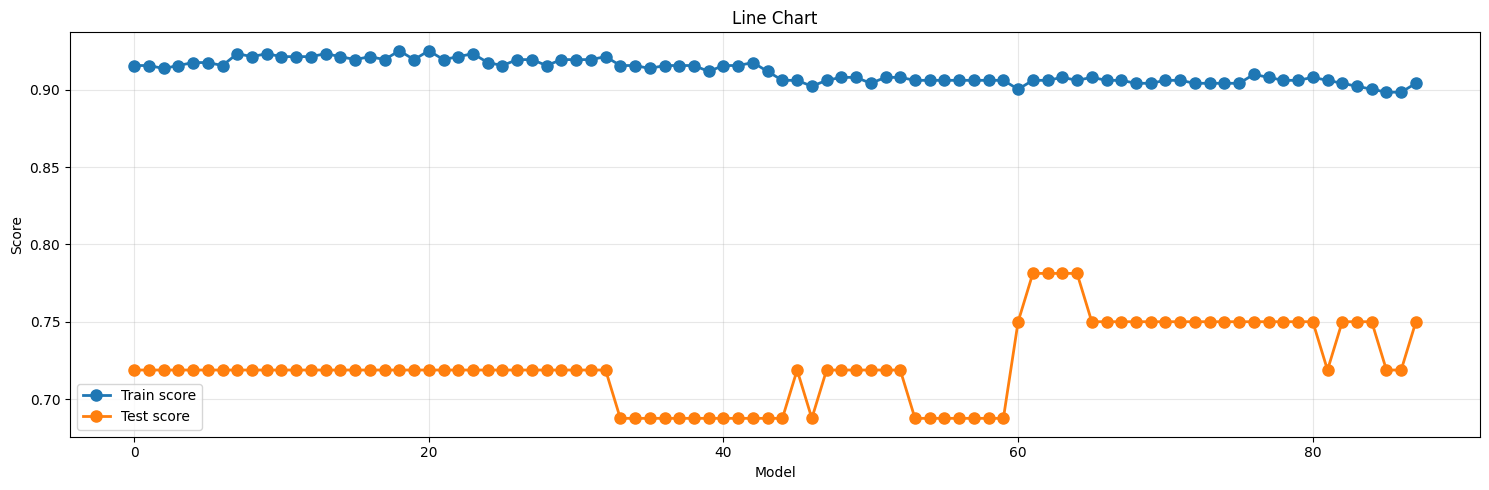

In [84]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(results_df.index, results_df['train_score'], marker='o', linewidth=2, markersize=8, label='Train score')
ax.plot(results_df.index, results_df['test_score'], marker='o', linewidth=2, markersize=8, label='Test score')
ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Line Chart')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()